In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from custom_classes import NasaDataset, SimpleAE, split_dataset, fix_seeds
from ae_metrics import MAPE
from normalisation import standard_scaling, min_max_scaling

import os
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [4]:
train_dataset = NasaDataset('../datasets/clean_train_data.csv')
fix_seeds(37)
train_dataset, test_dataset = split_dataset(train_dataset, test_size=0.1)
fix_seeds(37)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)
# test_dataset = NasaDataset('../datasets/test.csv')

for dtset in (train_dataset, val_dataset, test_dataset):
    dtset.to(device)
    standard_scaling(dtset)

fix_seeds(37)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
fix_seeds(37)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)
fix_seeds(37)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=..., shuffle=...)
print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 6, 3)

model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
optimiser = optim.Adam(model_ae.parameters(),
                       lr=1e-3)

Train: 13723
Validation: 4840
Test: 2068


In [5]:
models_path = '../Models/'
plots_path = '../Plots/history/'

In [6]:
def plot_history(history_df: pd.DataFrame, ylabel: str = None, save_path: str = None):
    history_df = history_df.melt(ignore_index=False).iloc[1:]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable')

    ax.set_ylabel(ylabel)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

 10/100: train_loss=0.2096, val_loss=0.2094, train_metrics=-34.7414%, val_metrics=-36.0895%
 20/100: train_loss=0.2081, val_loss=0.2081, train_metrics=-35.8535%, val_metrics=-36.9694%
 30/100: train_loss=0.2077, val_loss=0.2079, train_metrics=-36.3829%, val_metrics=-34.6884%
 40/100: train_loss=0.2094, val_loss=0.2089, train_metrics=-35.6965%, val_metrics=-35.6859%
 50/100: train_loss=0.2075, val_loss=0.2075, train_metrics=-35.7768%, val_metrics=-44.8699%
 60/100: train_loss=0.2075, val_loss=0.2074, train_metrics=-35.3935%, val_metrics=-34.8894%
 70/100: train_loss=0.2075, val_loss=0.2072, train_metrics=-35.3873%, val_metrics=-35.3044%
 80/100: train_loss=0.2074, val_loss=0.2074, train_metrics=-36.1366%, val_metrics=-35.4782%
 90/100: train_loss=0.2075, val_loss=0.2076, train_metrics=-35.7034%, val_metrics=-35.6150%
100/100: train_loss=0.2074, val_loss=0.2070, train_metrics=-35.1126%, val_metrics=-35.4658%

test_loss=0.2396, test_metrics=-324.5622


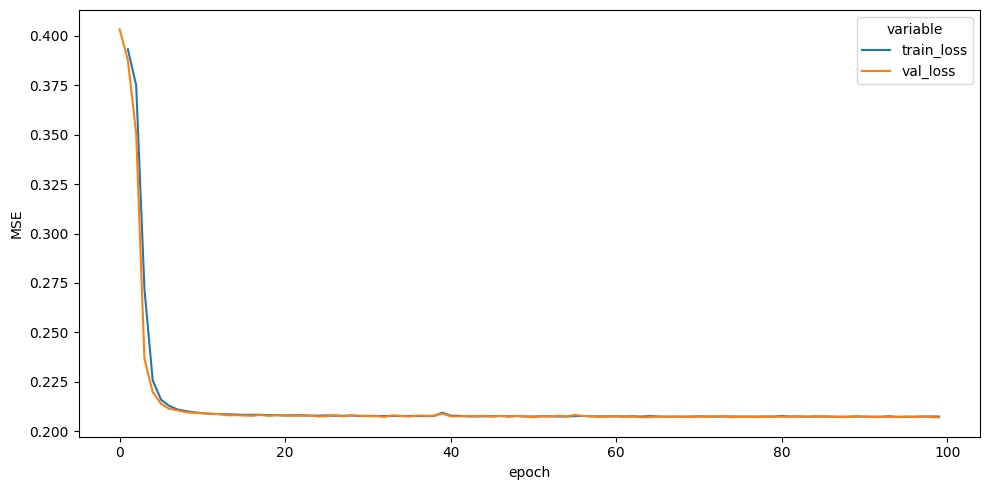

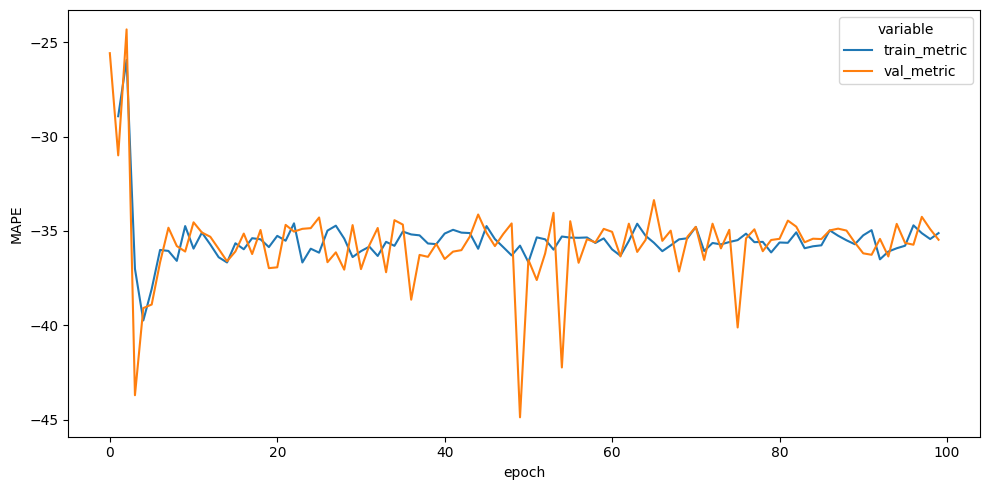

In [7]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    with torch.no_grad():
        val_losses = list()
        val_metrics = list()
        for dta in val_loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model_ae(sample)

            loss = loss_func(reconstruction, sample)
            metric = metric_func(reconstruction, sample)

            val_losses.append(loss.item())
            val_metrics.append(metric.item())
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

with torch.no_grad():
    test_losses = list()
    test_metrics = list()
    for sample in test_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)
        test_losses.append(loss.item())
        test_metrics.append(metric.item())
    test_loss = mean(test_losses)
    test_metrics = mean(test_metrics)
    print(f'\n{test_loss=:.4f}, {test_metrics=:.4f}')

# name = str(layers_sizes)
# torch.save(model_ae.state_dict(), os.path.join(models_path, f'{name}.pth'))

columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

history_df = total_history_df.loc[:,('train_loss', 'val_loss')]
plot_history(history_df, ylabel='MSE')

history_df = total_history_df.loc[:,('train_metric', 'val_metric')]
plot_history(history_df, ylabel='MAPE')